<a href="https://colab.research.google.com/github/WayneGretzky1/CSCI-4521-Applied-Machine-Learning/blob/main/3_3_regression_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorch & Tensors

He we are using `torch`, a new library that will allow us to take derivatives and work with tensors.

In [ ]:
import torch
import numpy as np

First, we make NumPy versions of the arrays:

In [ ]:
x = np.array([1,2,3,5])
y = np.array([5,8,11,17])

In [ ]:
x

array([1, 2, 3, 5])

And we can turn those NumPy arrays into Torch tensors. Tensors are similar to arrays (they both represent multi-dimensional grids of numbers, together with various basic linear algebra operations). However, PyTorch tensors allow additional capabilities with auto-differentiation.
 - PyTorch also better supports GPU acceleration (we'll see this later in the course).

In [ ]:
x = torch.Tensor(x)
y = torch.Tensor(y)

In [ ]:
x

tensor([1., 2., 3., 5.])

## Autodifferentiation

Here we make a new tensor `m`, that has `requires_grad` set to `True`. This means the tensor will keep track of whatever gradients are associated with its computations.

In [ ]:
m = torch.Tensor([1.0]).float()

In [ ]:
m.requires_grad = True

In [ ]:
m

tensor([1.], requires_grad=True)

As an example, let's define a variable `l` that is 10 times `m`.

In [ ]:
l = 10*m
l

tensor([10.], grad_fn=<MulBackward0>)

As `m` was `1.0`, `l` is of course `10.0` now.

To compute a gradient of every input variable with respect to a given output variable, use the `backward()` function as follows:
 - ```output_var.backward()```

For example, with our variable `l`:

In [ ]:
l.backward()   #fist call .backward() on the output variable
print(m.grad)  #then you can compute the gradient of output w.r.t inputs

tensor([10.])


We see that the derivative of `l` with respect to `m` is 10. That is $\frac{dl}{dm} = 10.0$. Looking back at our equation for `l` (`l = 10*m`), this makes sense.

We can see `m` had the original value of the tensors, which can be accessed with `.item()`, and the partial derivatives which can be accessed with `.grad`:

In [ ]:
print(m)
print(m.item())
print(m.grad)

tensor([1.], requires_grad=True)
1.0
tensor([10.])


Let's put together a bigger example.

In [ ]:
m = torch.Tensor([1.0]).float()
n = torch.Tensor([2.0]).float()
q = torch.Tensor([5.0]).float()
val = torch.Tensor([6.0]).float()
offset = torch.Tensor([4.1]).float()
m.requires_grad = True
n.requires_grad = True
q.requires_grad = True
val.requires_grad = True
offset.requires_grad = True

In [ ]:
l = 3*m + 2*n + val*q + offset
l

tensor([41.1000], grad_fn=<AddBackward0>)

Okay, we can now compute the partial of the output (`l`) with respect to each of the inputs:

In [ ]:
l.backward()

In [ ]:
print("dl/dm",m.grad)
print("dl/dn",n.grad)
print("dl/dq",q.grad)
print("dl/dval",val.grad)
print("dl/doffset",offset.grad)

dl/dm tensor([3.])
dl/dn tensor([2.])
dl/dq tensor([6.])
dl/dval tensor([5.])
dl/doffset tensor([1.])


## Linear Fitting

Let's try fitting a line to some data. We will assume the line is of the form `y = m*x + b`. Let's make some tensors to help with this model.

As we don't know what the optimal values of `m` and `b` will be, we'll just set them to `1.0` for now (an equally good strategy is to use a small random number).

In [ ]:
m = torch.Tensor([1.0]).float()
m.requires_grad = True

In [ ]:
b = torch.Tensor([1.0]).float()
b.requires_grad = True

I'm going to create some fake data. Let's assume the data with the following values: (1, 5), (2, 8), (3, 11), and (5, 17) ... where the first number is the feature and the second number is the observation.

First, we copy those values into tensors:

In [ ]:
x = torch.Tensor(np.array([1,2,3,5]))
y = torch.Tensor(np.array([5,8,11,17]))

Plotting the data reveals a clear linear trend:

<Axes: xlabel='None', ylabel='None'>

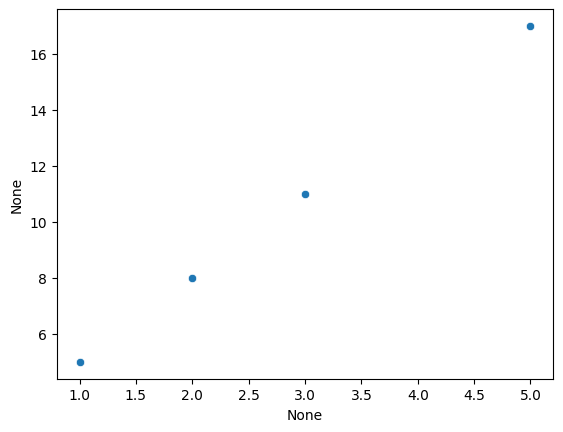

In [ ]:
import seaborn as sns
sns.scatterplot(y=y, x=x)

Let's see how good the model is when `m` and `b` are both `1.0`.

First, let's make new predicted y values:

In [ ]:
y_pred = m*x + b
y_pred

tensor([2., 3., 4., 6.], grad_fn=<AddBackward0>)

and store these values in a pandas dataframe for ease of plotting

In [ ]:
import pandas as pd
data_array = np.array([x.detach().numpy(),y.detach().numpy(),y_pred.detach().numpy()]).T
df = pd.DataFrame(data_array,columns=["x","y","y_pred"], index=[0,1,2,3])
df

,x,y,y_pred
0,1.0,5.0,2.0
1,2.0,8.0,3.0
2,3.0,11.0,4.0
3,5.0,17.0,6.0


In [ ]:
dfm = df.melt("x",var_name="kind")

<Axes: xlabel='x', ylabel='value'>

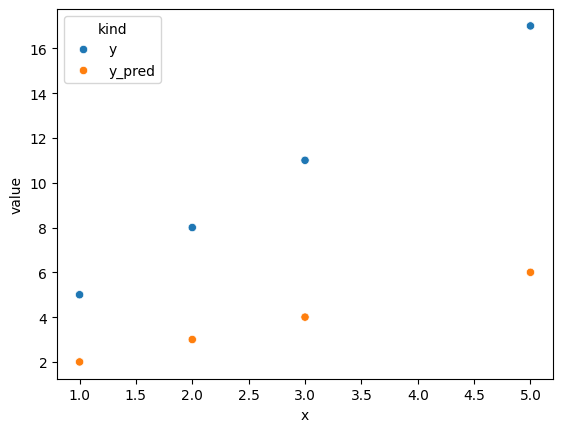

In [ ]:
sns.scatterplot(data=dfm,x="x",y="value",hue="kind")

It looks like all of our predicted values are too small. We can compute a `loss` function to measure the difference between the predicted values `y_pred` and the actual values `y`.

In [ ]:
loss = (y_pred - y)**2
loss

tensor([  9.,  25.,  49., 121.], grad_fn=<PowBackward0>)

This loss is the squared error. (Q: Why might the squared error be a better loss than the non-squared error?)

To turn this into a single number we can take the average of these losses (taking a vector to a single number is known as "reducing" it).

In [ ]:
loss = loss.mean()  #reduction
loss

tensor(51., grad_fn=<MeanBackward0>)

OK, now for some PyTorch magic!

We want the line to fit better. That means we want the loss to go lower. Taking the partial derivative of the loss with respect to each term in our model tells us if moving that term up will make the loss go up or down.

Calling `loss.backward()` with PyTorch will compute exactly these partials.

In [ ]:
loss.backward()

In [ ]:
m.grad    # dloss/dm

tensor([-44.5000])

In [ ]:
b.grad   # dloss/db

tensor([-13.])

Based on these partial derivatives, we can see that $\frac{d\mathrm{loss}}{dm}$  is negative, which means *increasing* the slope `m` will *decrease* the loss. That's exactly what we want! Likewise, we want to increase the y-intercept `b`.

If we increase our `m` and `b` too much, we can actually overshoot and make the loss bigger.

We use a strategy called "Gradient Descent". The idea is that we pick a small step size (called a *learning rate*) and make a small adjustment to each parameter of the learning rate times the gradient. Because moving in the direction of the gradient would make our loss go up, we move in the negative of the gradient to make the loss go down.

In [ ]:
lr = 0.001  #Define a small learning rate

In [ ]:
with torch.no_grad():
  m -= m.grad*lr     #Move each paramater in the negative ...
  b -= b.grad*lr     # ....of the gradient (reduce loss)
  print(m.item(),b.item())

1.0444999933242798 1.0130000114440918


Above, we used the `with torch.no_grad():` so that we could update `m` and `b` without PyTorch keeping track of the derivatives. This saves a bit of otherwise wasted computation.

We can use our updated `m` and `b` to make a new prediction `y_pred`, and we can see that the loss has gone down a bit!

In [ ]:
y_pred = m*x + b
loss = ((y_pred - y)**2).mean()
print(loss.item())

48.87340545654297


Now that we've updated `m` and `b`, we can zero out the gradients (to reset our partial derivative calculations) and do it all again:

In [ ]:
m.grad.zero_()
b.grad.zero_()

tensor([0.])

## Gradient Descent for Line Fitting

I'm going to go ahead and put everything we did above together in a loop so we can run it hundreds of times.

In [ ]:
x = torch.Tensor(np.array([1,2,3,5]))
y = torch.Tensor(np.array([5,8,11,17]))

In [ ]:
# Define learning rate
#lr = 2 / (torch.norm(x)*x.shape[0]) # analytical upper bound lr for guaranteed convergence
# print(lr)
lr = 0.09 #Larger lr goes faster, but what about too large an lr?


# Initialize parameters (initializing them small usually helps)
# making sure to tell pytorch these are the variables we will be taking the gradient over
m = torch.Tensor([1.0]).float()
m.requires_grad = True
b = torch.Tensor([1.0]).float()
b.requires_grad = True

# Gradient descent update loop
for epoch in range(1000):
  # forward pass
  y_pred = m*x+b
  # compute loss
  loss_tensor = (y_pred - y)**2
  loss = loss_tensor.mean()
  # compute the gradient of our loss function
  loss.backward()
  with torch.no_grad(): # don't need to include this computation in our gradient
    # update our parameters by using the learning rate to define step size
    m -= m.grad*lr
    b -= b.grad*lr
    # reset our gradients
    m.grad.zero_()
    b.grad.zero_()
  if epoch%20==0:
    print("epoch:",epoch,"m=",m.item(),"b=",b.item(),"loss=",loss.item())

epoch: 0 m= 5.005000114440918 b= 2.1700000762939453 loss= 51.0
epoch: 20 m= 3.269510269165039 b= 1.8871941566467285 loss= 0.6860507726669312
epoch: 40 m= 3.048922061920166 b= 1.9251344203948975 loss= 0.010670755058526993
epoch: 60 m= 3.013970136642456 b= 1.962473750114441 loss= 0.0004772515094373375
epoch: 80 m= 3.005500555038452 b= 1.9821773767471313 loss= 7.947679841890931e-05
epoch: 100 m= 3.002450704574585 b= 1.991641640663147 loss= 1.7010297597153112e-05
epoch: 120 m= 3.001131534576416 b= 1.9960923194885254 loss= 3.705486733451835e-06
epoch: 140 m= 3.0005264282226562 b= 1.9981740713119507 loss= 8.085364697762998e-07
epoch: 160 m= 3.0002453327178955 b= 1.9991470575332642 loss= 1.7661000129010063e-07
epoch: 180 m= 3.000114917755127 b= 1.9996017217636108 loss= 3.847645757559803e-08
epoch: 200 m= 3.000053882598877 b= 1.9998139142990112 loss= 8.368317594431574e-09
epoch: 220 m= 3.000025510787964 b= 1.9999128580093384 loss= 1.826549578254344e-09
epoch: 240 m= 3.000011920928955 b= 1.9999

After 100 epochs, the loss is already pretty low, and it continues to decrease.

Plotting the revised results, we can see that the predicted outputs fit the actual outputs almost perfectly.

Go back up and change the learning rate to 0.01, or even 0.1 and see if the method converges to the line of best fit any faster.

**TODO: find the smalles learning rate you can that will make the gradient explode!**

<Axes: xlabel='x', ylabel='value'>

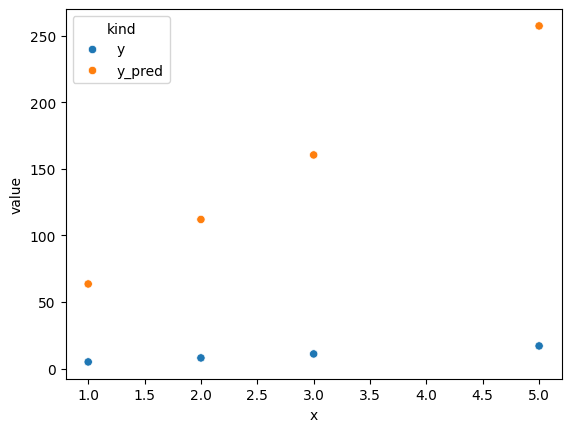

In [ ]:
df = pd.DataFrame(np.array([x.detach().numpy(),y.detach().numpy(),y_pred.detach().numpy()]).T,columns=["x","y","y_pred"], index=[0,1,2,3])
dfm = df.melt("x",var_name="kind")
sns.scatterplot(data=dfm,x="x",y="value",hue="kind")

Using Matplotlib we can plot the line of best fit to see how well it matches our data.

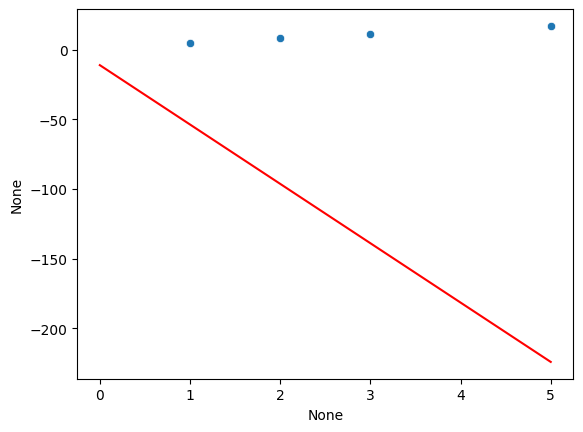

In [ ]:
import matplotlib.pyplot as plt
sns.scatterplot(x=x,y=y)
y_intercept =  b.detach().numpy()
slope =  m.detach().numpy()
plt.plot([0,5],[y_intercept,slope*5+y_intercept], color="red")

Here we used only 4 data points, and fit a simple linear model with only 2 free parameters. However, the same idea works with many more data points and much more complex models.